In [1]:
import mindspore
print(mindspore.__version__)

1.9.0


In [5]:

!tree cifar10

Folder PATH listing for volume Data
Volume serial number is 062F-F8A4
D:\PYTHON\JUPYTER\JUPYTERWORKSPACE\MINDSPOREWORK\RESNET\CIFAR10
├───test
└───train


In [15]:
import numpy as np
import mindspore.nn as nn
from mindspore import Tensor

In [6]:
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)

In [7]:
def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)

In [8]:
def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)

In [9]:
def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)

In [10]:
def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)


In [11]:
def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)

In [12]:
def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)

In [16]:
class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.

    Args:
        in_channel (int): Input channel.
        out_channel (int): Output channel.
        stride (int): Stride size for the first convolutional layer. Default: 1.

    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResidualBlock(3, 256, stride=2)
    """
    expansion = 4

    def __init__(self,
                 in_channel,
                 out_channel,
                 stride=1):
        super(ResidualBlock, self).__init__()

        channel = out_channel // self.expansion
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)

        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)

        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)

        self.relu = nn.ReLU()

        self.down_sample = False

        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None

        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride),
                                                        _bn(out_channel)])
        self.add = P.TensorAdd()

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.down_sample:
            identity = self.down_sample_layer(identity)

        out = self.add(out, identity)
        out = self.relu(out)

        return out

In [17]:
class ResNet(nn.Cell):
    """
    ResNet architecture.

    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        strides (list):  Stride size in each layer.
        num_classes (int): The number of classes that the training images are belonging to.
    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResNet(ResidualBlock,
        >>>        [3, 4, 6, 3],
        >>>        [64, 256, 512, 1024],
        >>>        [256, 512, 1024, 2048],
        >>>        [1, 2, 2, 2],
        >>>        10)
    """

    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 strides,
                 num_classes):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")

        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = P.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0])
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1])
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2])
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3])

        self.mean = P.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes)

In [30]:
def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make stage network of ResNet.

        Args:
            block (Cell): Resnet block.
            layer_num (int): Layer number.
            in_channel (int): Input channel.
            out_channel (int): Output channel.
            stride (int): Stride size for the first convolutional layer.

        Returns:
            SequentialCell, the output layer.

        Examples:
            >>> _make_layer(ResidualBlock, 3, 128, 256, 2)
        """
        layers = []

        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)

        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)

        return nn.SequentialCell(layers)

def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = self.mean(c5, (2, 3))
        out = self.flatten(out)
        out = self.end_point(out)

        return out

In [32]:
def resnet50(class_num=10):
    """
    Get ResNet50 neural network.

    Args:
        class_num (int): Class number.

    Returns:
        Cell, cell instance of ResNet50 neural network.

    Examples:
        >>> net = resnet50(10)
    """
    return ResNet(ResidualBlock,
                  [3, 4, 6, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)

[WARNING] ME(16844:8472,MainProcess):2022-11-13-16:25:08.789.684 [mindspore\dataset\core\validator_helpers.py:806] 'RandomCrop' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCrop' from mindspore.dataset.vision instead.
[WARNING] ME(16844:8472,MainProcess):2022-11-13-16:25:08.789.684 [mindspore\dataset\core\validator_helpers.py:806] 'RandomHorizontalFlip' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomHorizontalFlip' from mindspore.dataset.vision instead.
[WARNING] ME(16844:8472,MainProcess):2022-11-13-16:25:08.789.684 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(16844:8472,MainProcess):2022-11-13-16:25:08.789.684 [mindspore\dataset\core\va

The dataset size is: 1562
The batch tensor is: (32, 3, 224, 224)


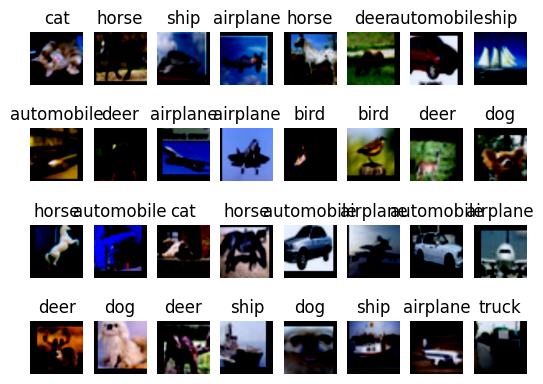

In [33]:
import mindspore.nn as nn
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2
from mindspore import context
import numpy as np
import matplotlib.pyplot as plt
 
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
 
def create_dataset(data_home, repeat_num=1, batch_size=32, do_train=True, device_target="CPU"):
    """
    create data for next use such as training or inferring
    """
 
    cifar_ds = ds.Cifar10Dataset(data_home,num_parallel_workers=8, shuffle=True)
 
    c_trans = []
    if do_train:
        c_trans += [
            C.RandomCrop((32, 32), (4, 4, 4, 4)),
            C.RandomHorizontalFlip(prob=0.5)
        ]
 
    c_trans += [
        C.Resize((224, 224)),
        C.Rescale(1.0 / 255.0, 0.0),
        C.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        C.HWC2CHW()
    ]
 
    type_cast_op = C2.TypeCast(mstype.int32)
 
    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=8)
    cifar_ds = cifar_ds.map(operations=c_trans, input_columns="image", num_parallel_workers=8)
 
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_num)
 
    return cifar_ds
 
 
ds_train_path = "cifar10/train/"
dataset_show = create_dataset(ds_train_path)
with open(ds_train_path+"batches.meta.txt","r",encoding="utf-8") as f:
    all_name = [name.replace("\n","") for name in f.readlines()]
 
iterator_show= dataset_show.create_dict_iterator()
dict_data = next(iterator_show)
images = dict_data["image"].asnumpy()
labels = dict_data["label"].asnumpy()
count = 1
%matplotlib inline
for i in images:
    plt.subplot(4, 8, count)
    # Images[0].shape is (3,224,224).We need transpose as (224,224,3) for using in plt.show().
    picture_show = np.transpose(i,(1,2,0))
    picture_show = picture_show/np.amax(picture_show)
    picture_show = np.clip(picture_show, 0, 1)
    plt.title(all_name[labels[count-1]])
    picture_show = np.array(picture_show,np.float32)
    plt.imshow(picture_show)
    count += 1
    plt.axis("off")
 
print("The dataset size is:", dataset_show.get_dataset_size())
print("The batch tensor is:",images.shape)
plt.show()

In [35]:
def weight_variable_0(shape):
    """weight_variable_0"""
    zeros = np.zeros(shape).astype(np.float32)
    return Tensor(zeros)


def weight_variable_1(shape):
    """weight_variable_1"""
    ones = np.ones(shape).astype(np.float32)
    return Tensor(ones)


def conv3x3(in_channels, out_channels, stride=1, padding=0):
    """3x3 convolution """
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=3, stride=stride, padding=padding, weight_init='XavierUniform',
                     has_bias=False, pad_mode="same")


def conv1x1(in_channels, out_channels, stride=1, padding=0):
    """1x1 convolution"""
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=1, stride=stride, padding=padding, weight_init='XavierUniform',
                     has_bias=False, pad_mode="same")


def conv7x7(in_channels, out_channels, stride=1, padding=0):
    """1x1 convolution"""
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=7, stride=stride, padding=padding, weight_init='XavierUniform',
                     has_bias=False, pad_mode="same")


def bn_with_initialize(out_channels):
    """bn_with_initialize"""
    shape = (out_channels)
    mean = weight_variable_0(shape)
    var = weight_variable_1(shape)
    beta = weight_variable_0(shape)
    bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=0.00001, gamma_init='Uniform',
                        beta_init=beta, moving_mean_init=mean, moving_var_init=var)
    return bn


def bn_with_initialize_last(out_channels):
    """bn_with_initialize_last"""
    shape = (out_channels)
    mean = weight_variable_0(shape)
    var = weight_variable_1(shape)
    beta = weight_variable_0(shape)
    bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=0.00001, gamma_init='Uniform',
                        beta_init=beta, moving_mean_init=mean, moving_var_init=var)
    return bn


def fc_with_initialize(input_channels, out_channels):
    """fc_with_initialize"""
    return nn.Dense(input_channels, out_channels, weight_init='XavierUniform', bias_init='Uniform')


class ResidualBlock(nn.Cell):
    """ResidualBlock"""
    expansion = 4

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1):
        """init block"""
        super(ResidualBlock, self).__init__()

        out_chls = out_channels // self.expansion
        self.conv1 = conv1x1(in_channels, out_chls, stride=stride, padding=0)
        self.bn1 = bn_with_initialize(out_chls)

        self.conv2 = conv3x3(out_chls, out_chls, stride=1, padding=0)
        self.bn2 = bn_with_initialize(out_chls)

        self.conv3 = conv1x1(out_chls, out_channels, stride=1, padding=0)
        self.bn3 = bn_with_initialize_last(out_channels)

        self.relu = ops.ReLU()
        self.add = ops.Add()

    def construct(self, x):
        """construct"""
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.add(out, identity)
        out = self.relu(out)

        return out


class ResidualBlockWithDown(nn.Cell):
    """ResidualBlockWithDown"""
    expansion = 4

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1,
                 down_sample=False):
        """init block with down"""
        super(ResidualBlockWithDown, self).__init__()

        out_chls = out_channels // self.expansion
        self.conv1 = conv1x1(in_channels, out_chls, stride=stride, padding=0)
        self.bn1 = bn_with_initialize(out_chls)

        self.conv2 = conv3x3(out_chls, out_chls, stride=1, padding=0)
        self.bn2 = bn_with_initialize(out_chls)

        self.conv3 = conv1x1(out_chls, out_channels, stride=1, padding=0)
        self.bn3 = bn_with_initialize_last(out_channels)

        self.relu = ops.ReLU()
        self.down_sample = down_sample

        self.conv_down_sample = conv1x1(in_channels, out_channels, stride=stride, padding=0)
        self.bn_down_sample = bn_with_initialize(out_channels)
        self.add = ops.Add()

    def construct(self, x):
        """construct"""
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.conv_down_sample(identity)
        identity = self.bn_down_sample(identity)

        out = self.add(out, identity)
        out = self.relu(out)

        return out


class MakeLayer0(nn.Cell):
    """MakeLayer0"""

    def __init__(self, block, in_channels, out_channels, stride):
        """init"""
        super(MakeLayer0, self).__init__()
        self.a = ResidualBlockWithDown(in_channels, out_channels, stride=1, down_sample=True)
        self.b = block(out_channels, out_channels, stride=stride)
        self.c = block(out_channels, out_channels, stride=1)

    def construct(self, x):
        """construct"""
        x = self.a(x)
        x = self.b(x)
        x = self.c(x)

        return x


class MakeLayer1(nn.Cell):
    """MakeLayer1"""

    def __init__(self, block, in_channels, out_channels, stride):
        """init"""
        super(MakeLayer1, self).__init__()
        self.a = ResidualBlockWithDown(in_channels, out_channels, stride=stride, down_sample=True)
        self.b = block(out_channels, out_channels, stride=1)
        self.c = block(out_channels, out_channels, stride=1)
        self.d = block(out_channels, out_channels, stride=1)

    def construct(self, x):
        """construct"""
        x = self.a(x)
        x = self.b(x)
        x = self.c(x)
        x = self.d(x)

        return x


class MakeLayer2(nn.Cell):
    """MakeLayer2"""

    def __init__(self, block, in_channels, out_channels, stride):
        """init"""
        super(MakeLayer2, self).__init__()
        self.a = ResidualBlockWithDown(in_channels, out_channels, stride=stride, down_sample=True)
        self.b = block(out_channels, out_channels, stride=1)
        self.c = block(out_channels, out_channels, stride=1)
        self.d = block(out_channels, out_channels, stride=1)
        self.e = block(out_channels, out_channels, stride=1)
        self.f = block(out_channels, out_channels, stride=1)

    def construct(self, x):
        """construct"""
        x = self.a(x)
        x = self.b(x)
        x = self.c(x)
        x = self.d(x)
        x = self.e(x)
        x = self.f(x)

        return x


class MakeLayer3(nn.Cell):
    """MakeLayer3"""

    def __init__(self, block, in_channels, out_channels, stride):
        """init"""
        super(MakeLayer3, self).__init__()
        self.a = ResidualBlockWithDown(in_channels, out_channels, stride=stride, down_sample=True)
        self.b = block(out_channels, out_channels, stride=1)
        self.c = block(out_channels, out_channels, stride=1)

    def construct(self, x):
        """construct"""
        x = self.a(x)
        x = self.b(x)
        x = self.c(x)

        return x


class ResNet(nn.Cell):
    """ResNet"""

    def __init__(self, block, num_classes=100, batch_size=32):
        """init"""
        super(ResNet, self).__init__()
        self.batch_size = batch_size
        self.num_classes = num_classes

        self.conv1 = conv7x7(3, 64, stride=2, padding=0)

        self.bn1 = bn_with_initialize(64)
        self.relu = ops.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.layer1 = MakeLayer0(block, in_channels=64, out_channels=256, stride=1)
        self.layer2 = MakeLayer1(block, in_channels=256, out_channels=512, stride=2)
        self.layer3 = MakeLayer2(block, in_channels=512, out_channels=1024, stride=2)
        self.layer4 = MakeLayer3(block, in_channels=1024, out_channels=2048, stride=2)

        self.pool = ops.ReduceMean(keep_dims=True)
        self.squeeze = ops.Squeeze(axis=(2, 3))
        self.fc = fc_with_initialize(512 * block.expansion, num_classes)

    def construct(self, x):
        """construct"""
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.pool(x, (2, 3))
        x = self.squeeze(x)
        x = self.fc(x)
        return x


def resnet50(batch_size, num_classes):
    """create resnet50"""
    return ResNet(ResidualBlock, num_classes, batch_size)

In [37]:
import mindspore.ops as ops 
net = resnet50(batch_size=32, num_classes=10)

In [39]:
import mindspore.nn as nn
from mindspore.nn import SoftmaxCrossEntropyWithLogits
 
ls = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
opt = nn.Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.01, 0.9)


In [ ]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import load_checkpoint, load_param_into_net
import os
from mindspore import Model
 
 
model = Model(net, loss_fn=ls, optimizer=opt, metrics={'acc'})
# As for train, users could use model.train
 
epoch_size = 10
ds_train_path = "cifar10/train/"
model_path = "models/ckpt/mindspore_vision_application/"
os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))
 
dataset = create_dataset(ds_train_path )
batch_num = dataset.get_dataset_size()
config_ck = CheckpointConfig(save_checkpoint_steps=batch_num, keep_checkpoint_max=35)
ckpoint_cb = ModelCheckpoint(prefix="train_resnet_cifar10", directory=model_path, config=config_ck)
loss_cb = LossMonitor(142)
model.train(epoch_size, dataset, callbacks=[ckpoint_cb, loss_cb])

[WARNING] ME(16844:8472,MainProcess):2022-11-13-16:34:48.696.841 [mindspore\dataset\core\validator_helpers.py:806] 'RandomCrop' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCrop' from mindspore.dataset.vision instead.
[WARNING] ME(16844:8472,MainProcess):2022-11-13-16:34:48.697.837 [mindspore\dataset\core\validator_helpers.py:806] 'RandomHorizontalFlip' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomHorizontalFlip' from mindspore.dataset.vision instead.
[WARNING] ME(16844:8472,MainProcess):2022-11-13-16:34:48.697.837 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(16844:8472,MainProcess):2022-11-13-16:34:48.698.833 [mindspore\dataset\core\va